<a href="https://colab.research.google.com/github/jepilogo97/nlp/blob/main/nlp-with-transformers/nlp_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP con BERT

##### Jean Pierre Londoño González
##### Mini-Proyecto de clasificación de texto con Transformers
##### 14SEP2025

En este notebook se implementa un clasificador de reseñas de zapatos de amazon utilizando Bert. El dataset empleado corresponde a 
amazon-shoe-reviews, disponible en Hugging Face, el cual contiene reseñas en inglés con un respectivo score entre 0 y 4. Se realizará uso extensivo de la herramientas de Hugging Face, las cuales están especialmente desarrolladas para este tipo de tareas, incluyendo la interacción con modelos pre-entrenados.

#### Referencias
- Dataset: https://huggingface.co/datasets/excode/amazon-shoe-reviews

### 1. Importación de librerias y carga de modelos

Inicio importando las librerías necesarias para el procesamiento de lenguaje natural, la manipulación de datos y la construcción del modelo. Esto incluye NumPy y pandas para el manejo y análisis de datos; Hugging Face Datasets y Transformers para la carga de corpus y la tokenización; y PyTorch junto con PyTorch Lightning para definir, entrenar y evaluar el modelo de manera estructurada.

Además, se emplean torchmetrics y scikit-learn para calcular métricas de rendimiento como precisión, matrices de confusión y reportes de clasificación, mientras que Optuna permite la optimización automática de hiperparámetros.

Finalmente, tqdm facilita el seguimiento del progreso de los procesos iterativos.

In [31]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

C:\Users\jepil\AppData\Local\Temp\ipykernel_10276\2396000874.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
!wget -O requirements.txt https://raw.githubusercontent.com/jepilogo97/nlp/main/nlp-with-bert/requirements.txt
!pip install -r requirements.txt

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [4]:
pip install --upgrade pyarrow

  Using cached pyarrow-21.0.0-cp310-cp310-win_amd64.whl.metadata (3.4 kB)
Using cached pyarrow-21.0.0-cp310-cp310-win_amd64.whl (26.2 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.0
    Uninstalling pyarrow-19.0.0:
      Successfully uninstalled pyarrow-19.0.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Procesamiento de lenguaje natural y utilidades
import numpy as np  # Cálculo numérico y manejo de arreglos multidimensionales
import pandas as pd  # Manipulación y análisis de datos en estructuras tipo DataFrame

pd.set_option("display.max_rows", None)     # Todas las filas
pd.set_option("display.max_columns", None)  # Todas las columnas
pd.set_option("display.width", None)        # No cortar líneas

from datasets import Dataset, load_dataset, concatenate_datasets  # Carga y combinación de datasets de Hugging Face
from datasets.dataset_dict import DatasetDict
from collections import Counter  # Conteo de frecuencias de elementos (tokens, palabras, etc.)
import os  # Manejo de rutas, archivos y operaciones del sistema de archivos
import math  # Funciones matemáticas avanzadas (logaritmos, potencias, trigonometría, etc.)

import matplotlib.pyplot as plt
# Deep Learning con PyTorch
import torch  # Librería principal de tensores y operaciones en GPU/CPU
import torch.nn as nn  # Definición de capas y módulos de redes neuronales
import torch.nn.functional as F  # Funciones de activación y operaciones matemáticas de redes
from torch.utils.data import random_split, DataLoader, Subset  # Utilidades para crear y dividir datasets, cargar lotes y trabajar con subconjuntos
from torchinfo import summary

# Entrenamiento estructurado con PyTorch Lightning
from pytorch_lightning import LightningModule, Trainer  # Clase base y manejador de entrenamiento de modelos
from pytorch_lightning.loggers import TensorBoardLogger  # Registro de métricas e historial en TensorBoard
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint  # Detener entrenamiento si no mejora la métrica
from torchmetrics import Accuracy  # Métrica de precisión para clasificación supervisada

# Tipado para mayor legibilidad y validación de funciones
from typing import Tuple, Dict, Optional  # Definición de tipos de datos para funciones y estructuras
from enum import Enum  # Definición de enumeraciones (conjuntos de valores constantes con nombre)

from tqdm.auto import tqdm  # Barra de progreso adaptable para bucles
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments  # Tokenizador automático de modelos preentrenados de Hugging Face
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode  # Conversión de bytes a caracteres Unicode (usado en tokenización tipo GPT-2)

from typing import Dict, Any
import evaluate

import optuna  # Optimización automática de hiperparámetros mediante búsquedas eficientes (Bayesian, TPE, etc.)
from optuna.importance import get_param_importances
import optuna.visualization as vis

# Métricas de evaluación con Scikit-learn
from sklearn.model_selection import train_test_split  # División de datos en conjuntos de entrenamiento y prueba
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Métricas de evaluación de modelos de clasificación

C:\Users\jepil\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Cargue de datos

Este dataset contiene 2.2k conversaciones multi-turno generadas por Llama-3.1-70B-Instruct. Se le solicitó al modelo generar una conversación sencilla, con 3 a 4 intercambios breves, entre un Usuario y un Asistente de IA sobre un tema específico.

De este dataset se utilizarán específicamente las conversaciones entre el usuario y el asistente de IA, con el fin de asignarlas al tópico correspondiente. Cada ejemplo consiste en un diálogo corto multi-turno, donde el modelo debe identificar el tema principal a partir del intercambio entre ambas partes.

Está disponible en el Hugging Face Hub, lo que permite descargarlo fácilmente y utilizarlo directamente en entrenamientos o pruebas de modelos de NLP.

In [2]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
dataset = load_dataset("excode/amazon-shoe-reviews")
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 90000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

El dataset incluye 2 columas: El texto asociado a la reseña de los zapatos y la categoría a la que pertenece nivel de calificación). Para entrenar y validar el modelo, se dispone de 90.000 filas en el conjunto de entrenamiento y 10.000 en el conjunto de prueba.

Concatenos los dos datasets para tener mayor cantidad de datos.

In [3]:
tr_dataset = dataset["train"]
te_dataset = dataset["test"]
full_dataset = concatenate_datasets([tr_dataset, te_dataset])

Observemos uno de sus registros

In [4]:
full_dataset[0]

{'labels': 3,
 'text': 'Good shoe for office work. They will scuff very easy so be aware.'}

In [5]:
full_dataset.set_format(type="pandas")
df = full_dataset.to_pandas()
df.head()

,labels,text
0,3,Good shoe for office work. They will scuff ver...
1,1,I have had the Patricia II wedge in black for ...
2,1,Width not right and size too small if width ha...
3,0,I received these shoes and they weren't the sa...
4,2,They began to split alone the mesh material af...


Organizamos las columnas de interés.

In [6]:
df = df[["text", "labels"]] 

Ajusto el nombre de las columnas a text y category.

In [7]:
df = df.rename(columns={
    "text": "text",
    "labels": "category"
})

In [8]:
id2category = dict(enumerate(np.unique(df['category'])))
category2id = {v: k for k, v in id2category.items()}

Ahora observemos algunos de los registros ya ajustados.

In [9]:
df.head()

,text,category
0,Good shoe for office work. They will scuff ver...,3
1,I have had the Patricia II wedge in black for ...,1
2,Width not right and size too small if width ha...,1
3,I received these shoes and they weren't the sa...,0
4,They began to split alone the mesh material af...,2


Primero, observemos la distribución de las clases:

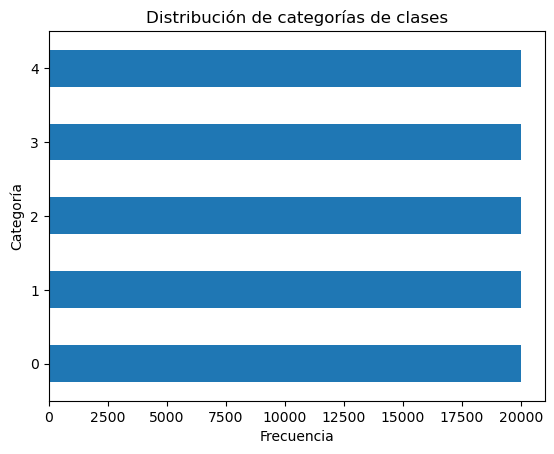

In [10]:
(df['category'].value_counts().sort_index().plot.barh())
plt.title('Distribución de categorías de clases')
plt.xlabel('Frecuencia')
plt.ylabel('Categoría')
plt.show()

Se encuentra que el dataset esta desbalanceado, pues algunas categorias tienes 100 registros pero otros 10.

Para efectos de la tarea solo utilizaremos las categorias que tienen una muestra suficiente y permite tener el dataset balanceado.

In [11]:
df.category.value_counts()

category
3    20000
1    20000
0    20000
2    20000
4    20000
Name: count, dtype: int64

In [12]:
df.shape

(100000, 2)

Observamos que es un dataset balanceado.

Ahora observemos la dispersión de las palabras por cada categoría.

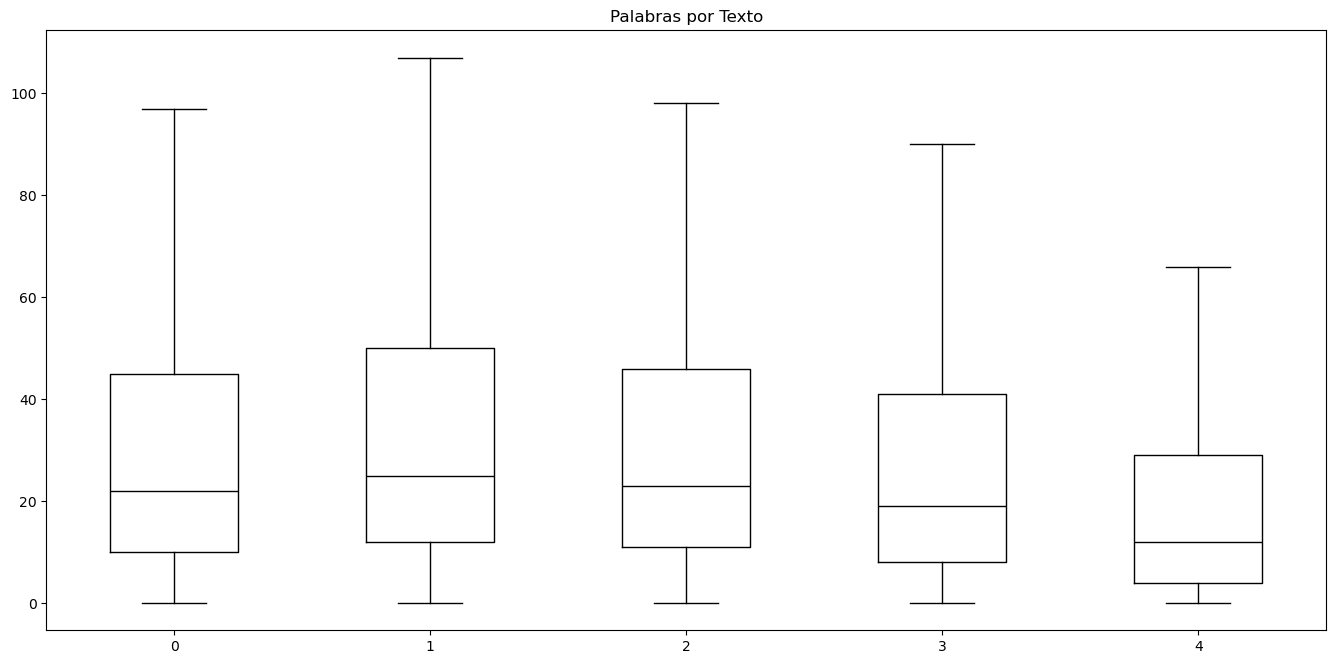

In [13]:
df['Palabras por Texto'] = df['text'].str.split().apply(len)
df.boxplot('Palabras por Texto', by='category', grid=False, showfliers=False, color='black', figsize=(16, 8))
plt.suptitle('')
plt.xlabel('')
plt.show()

Aquí observamos mayor diversidad. Observamos que algunas clases tienden a tener más palabras que otras, e incluso algunas tienen outliers en cuanto a la longitud de los textos. Sin embargo, como nuestra tarea es de clasificación según el texto y durante el entrenamiento vamos a manejar cadenas de tamaño fijo, lo que nos debería importar más que todo es la media/mediana entre todas las categorías.

In [14]:
df.groupby('category')['Palabras por Texto'].median()

category
0    22.0
1    25.0
2    23.0
3    19.0
4    12.0
Name: Palabras por Texto, dtype: float64

Como podemos observar, la mediana, que como media de tendencia central, tiende a ser más robusta que la media, nos indica que la longitud mediana de los textos entre todas las categorías tiende a rondar por las $\approx20$ palabras. Entonces utilizaremos una longitud de texto acorde durante nuestro entrenamiento.

### 2. Definición del Tokenizer

Como la idea en este notebook es la de re-utilizar modelos pre-entrenados, algo a tener en cuenta es que para que esto funcione correctamente, debemos **siempre** utilizar el mismo tokenizador que se usó para entrenar el modelo. Recordemos que el tokenizador asigna un código a cada token del vocabulario, y durante la creación de los embeddings, el modelo asume esto como entrada, por lo que su usamos otro tokenizador, el modelo va a ser incapaz de derivar las relaciones semánticas apropiadas.

Para esta tarea, haremos uso de un modelo BERT LARGE. El modelo puede ser encontrado [aquí](https://huggingface.co/google-bert/bert-large-uncased).

In [15]:
model_ckpt = "google-bert/bert-large-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

C:\Users\jepil\anaconda3\envs\nlp\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Ahora sometamos a prueba el tokenizador con una frase de prueba.

In [16]:
tokenizer.pad_token = '[PAD]'
tokenizer("hello world!!", max_length=10, truncation=True, padding='max_length').tokens()

['[CLS]',
 'hello',
 'world',
 '!',
 '!',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Algo interesante, este tokenizador, por lo menos para las palabras de esta frase de prueba, no separa en tokens distintos estas palabras, esto es justamente la razón por la cual no deberíamos usar un tokenizador diferente con un modelo pre-entrenado, habríamos obtenido tokens diferentes y el modelo no lograría interpretar la semantica como se espera.

Ahora, observemos su vocabulario.

In [17]:
tokenizer.vocab_size

30522

Tenemos $30522$ tokens, es una cantidad suficientemente amplio para una tarea de NLP.

Ahora, observemos otros parámetros del tokenizador.

In [18]:
tokenizer.model_max_length

512

In [19]:
tokenizer.model_input_names

['input_ids', 'token_type_ids', 'attention_mask']

Primero, observamos que el tokenizador por defecto maneja un tamaño de secuencia de $512$, mucho mayor a la longitud mediana de nuestro dataset, por lo que resulta perfecto para nuestro caso de uso. Finalmente, observamos sus salidas, las cuales serán las entradas a nuestro modelo. Como ya debemos saber, `input_ids` son los indices de los tokens y `attention_mask` es la máscara de atención cuando tenemos tokens irrelevantes (como el padding) en la cadena.

### 3. BERT pre-entrenado como featurizer (simple)

Ahora podemos proceder a definir el dataset.

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
inputs = tokenizer("hello world!!!", max_length=10, truncation=True, padding='max_length', return_tensors='pt')

print(f"Input Shapes & Types:")
print({k: (v.shape, v.dtype) for k, v in inputs.items()})

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(category2id)).to(device)

# Congelamos los pesos del modelo base para usarlo como featurizer solamente.
for param in model.base_model.parameters():
    param.requires_grad = False
    

input_sizes = [inputs['input_ids'].shape] * 3
input_types = [inputs['input_ids'].dtype] * 3
with torch.no_grad():
    print(summary(model, input_size=input_sizes, dtypes=input_types, col_names=['input_size', 'output_size', 'num_params', 'trainable']))

Input Shapes & Types:
{'input_ids': (torch.Size([1, 10]), torch.int64), 'token_type_ids': (torch.Size([1, 10]), torch.int64), 'attention_mask': (torch.Size([1, 10]), torch.int64)}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
BertForSequenceClassification                           [1, 10]                   [1, 5]                    --                        Partial
├─BertModel: 1-1                                        [1, 10]                   [1, 1024]                 --                        False
│    └─BertEmbeddings: 2-1                              --                        [1, 10, 1024]             --                        False
│    │    └─Embedding: 3-1                              [1, 10]                   [1, 10, 1024]             (31,254,528)              False
│    │    └─Embedding: 3-2                              [1, 10]                   [1, 10, 1024]             (2,048)                   False
│    │    └─Embedding: 3-3                              [1, 10]                   [1, 10, 1024]             (524,288)                 False
│    │    └─La

Observamos que el modelo tiene una capa `BertModel` que corresponde al modelo pre-entrenado y finaliza con una capa lineal que sería nuestro clasificador, esta es una capa proporcionada para nosotros al momento de inicializar el modelo. Además, observamos que solamente la capa lineal que hemos especificado tiene parámetros entrenables. Entonces, a pesar de que el modelo en si tiene más de 300 millones de parámetros, solamente menos de 5 mil son entrenables.

Observemos todos los modulos registrados en el modelo:

In [21]:
modules = [m for m, _ in model.named_modules()]
modules

['',
 'bert',
 'bert.embeddings',
 'bert.embeddings.word_embeddings',
 'bert.embeddings.position_embeddings',
 'bert.embeddings.token_type_embeddings',
 'bert.embeddings.LayerNorm',
 'bert.embeddings.dropout',
 'bert.encoder',
 'bert.encoder.layer',
 'bert.encoder.layer.0',
 'bert.encoder.layer.0.attention',
 'bert.encoder.layer.0.attention.self',
 'bert.encoder.layer.0.attention.self.query',
 'bert.encoder.layer.0.attention.self.key',
 'bert.encoder.layer.0.attention.self.value',
 'bert.encoder.layer.0.attention.self.dropout',
 'bert.encoder.layer.0.attention.output',
 'bert.encoder.layer.0.attention.output.dense',
 'bert.encoder.layer.0.attention.output.LayerNorm',
 'bert.encoder.layer.0.attention.output.dropout',
 'bert.encoder.layer.0.intermediate',
 'bert.encoder.layer.0.intermediate.dense',
 'bert.encoder.layer.0.intermediate.intermediate_act_fn',
 'bert.encoder.layer.0.output',
 'bert.encoder.layer.0.output.dense',
 'bert.encoder.layer.0.output.LayerNorm',
 'bert.encoder.layer.0

Observamos que la capa final es efectivamente el clasificador. Ahora hagamos una prueba pasando un dummy input:

In [22]:
with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
print({k: v.shape for k, v in outputs.items()})

{'logits': torch.Size([1, 5])}


In [23]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.0803, -0.3081, -0.1441,  0.3440, -0.0736]]), hidden_states=None, attentions=None)

In [24]:
model.classifier

Linear(in_features=1024, out_features=5, bias=True)

Observamos que tras invocar el modelo, en efecto, obtenemos una salida de 5 dimensiones, correspondientes al número de clases.

Ahora preparemos los datos para el entrenamiento.

Hugging Face Datasets convenientemente implementa una función para hacer el train-test splig en nuestro dataset y automáticamente creará nuevas llaves en el mismo para diferenciarlo.

In [25]:
dataset = Dataset.from_pandas(df)

In [26]:
training_dataset = dataset.train_test_split(train_size=0.8)
validation_dataset = training_dataset['test'].train_test_split(train_size=0.5)

In [27]:
new_dataset = DatasetDict({
    'train': training_dataset['train'],
    'val': validation_dataset['train'],
    'test': validation_dataset['test'],
})
new_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'category', 'Palabras por Texto'],
        num_rows: 80000
    })
    val: Dataset({
        features: ['text', 'category', 'Palabras por Texto'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'category', 'Palabras por Texto'],
        num_rows: 10000
    })
})

Tenemos nuestros tres conjuntos, sin embargo, esto es la información cruda, debemos preparar los datos para el modelo, lo gual incluye tokenizar y convertir las categorías a ids. Preparamos entonces unas funciones utilitarias.

In [28]:
def preprocess_function(max_len):
    def _preprocess_function(examples):
        return tokenizer(examples['text'], max_length=max_len, truncation=True, padding='max_length')
    return _preprocess_function

def tokenize(max_len: int = 8):
    def _tokenize(batch):
        return tokenizer(batch['text'], max_length=max_len, truncation=True, padding='max_length')
    return _tokenize

def category_names_2_ids(batch):
    batch['label'] = category2id[batch['category']]
    return batch

Y procedemos a invocarlas. Nótese que para la tokenización, estamos forzando a que las cadenas sean de 20 tokens, según el análisis que hemos hecho anteriormente.

In [29]:
tokenized_dataset = new_dataset.map(preprocess_function(max_len=20), batched=True)
tokenized_dataset = tokenized_dataset.map(category_names_2_ids)
tokenized_dataset

Map: 100%|██████████| 10000/10000 [00:01<00:00, 9954.99 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'category', 'Palabras por Texto', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 80000
    })
    val: Dataset({
        features: ['text', 'category', 'Palabras por Texto', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'category', 'Palabras por Texto', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
        num_rows: 10000
    })
})

### 4. Entrenamiento

Ahora procederemos al entrenamiento. Aquí harémos uso de las API de HuggingFace directamente.

In [32]:
# Definimos la función métrica de calidad
accuracy = evaluate.load("accuracy")

def compute_metrics(pred) -> Dict[str, Any]:
    """compute metrics

    Esta función será invocada en
    cada epoca y la utilizaremos para
    calcular la métrica de calidad.
    """ 
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1) 
    # Retorna un diccionario como {'nombre-metrica': valor}
    acc = accuracy.compute(predictions=preds, references=labels)
    return acc


batch_size = 8 if IN_COLAB else 4
logging_steps = len(tokenized_dataset['train']) // batch_size
# Definimos los parámetros globales de entrenamiento
training_args = TrainingArguments(
    output_dir='./hf',
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_eval_batch_size=batch_size,
    per_device_train_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=logging_steps,
    report_to='tensorboard'
)

# Y definimos el entrenador, especificando el modelo, datasets y el tokenizador
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'eval_strategy'

Con esto nos basta para ejecutar el entrenamiento:

In [ ]:
%%time
trainer.train()

Algo importante a resaltar es que fueron necesarias solo 2 iteraciones para alcanzar un ta tasa de correctitud $\approx 79%$, algo que con el modelo de transformers crudo nos costó muchas más iteraciones. Esto demuestra la importancia de partir de modelos pre-entrenados para este tipo de tareas.

Una ventaja adicional de Hugging Face transformers, es que publica automáticamente el progreso del entrenamiento a tensorboard, en el directorio que hemos especificado. Observemos entonces el proceso de entrenamiento:

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir hf/runs

Y ahora evaluemos el modelo en el conjunto de prueba:

In [ ]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

Hemos alcanzado una correctitud del $\approx 80\%$, lo cual, nuevamente, en comparación con el modelo de transformers crudo nos costó muchisimo más lograr.

### 5. Resultados

Ahora, hagamos predicciónes con el modelo y observemos los resultados.

In [ ]:
predictions = trainer.predict(tokenized_dataset['test'])
predictions

In [ ]:
predicted_labels = np.argmax(predictions.predictions, axis=-1)
test_set = tokenized_dataset['test']
test_set = test_set.add_column('prediction_label', predicted_labels)
test_set = test_set.add_column('prediction', list(map(lambda label: id2category[label], predicted_labels)))
test_set

In [ ]:
columns = ['text', 'label', 'prediction_label', 'category', 'prediction']
test_set.set_format('pandas', columns=columns)
df = test_set.to_pandas()[columns]
df.style.set_table_styles(
    [
        {'selector': 'td', 'props': [('word-wrap', 'break-word')]}
    ]
)
df.head(15)

Los resultados no lucen nada mal, aún se cometen un par de errores, pero de resto, parece bastante aceptable. Observemos los errores

In [ ]:
errors = df[df['label'] != df['prediction_label']]
errors.head(15)

Los errores parece que son mucho más interesantes que en nuestro mdelo pasado.

Los errores parecen algo mucho más genuino, economía y política son categorías que tienen algo de superposición entre si, al igual que motor y deportes, según sea el caso.

## Usando una capa más especializada como clasificador

Quizás podemos hacerlo mejor, hemos observado que por defecto, cuando cargamos la clase, Hugging Face nos da un clasificador muy simple, solo una capa lineal. Pero podemos utilizar un clasificador más complejo que definamos nosotros. Esta técnica seguiría utilizando el resto del modelo como featurizer, pero ahora añadimos complejidad a la capa de clasificación en búsqueda de una mejor calidad en los resutlados.

Entonces, volvemos a cargar el modelo tal como hemos hecho antes:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(category2id)).to(device)

for param in model.base_model.parameters():
    param.requires_grad = False
    
  
input_sizes = [inputs['input_ids'].shape] * 3
input_types = [inputs['input_ids'].dtype] * 3
with torch.no_grad():
    print(summary(model, input_size=input_sizes, dtypes=input_types, col_names=['input_size', 'output_size', 'num_params', 'trainable']))

In [ ]:
model.classifier

### Definiendo un clasificador propio

Podemos definir cualquier tipo de clasificador que se nos ocurra, siempre que se ajuste a las entradas y salidas del clasificador existente. Vamos a utilizar por ejemplo la misma capa lineal que definimos en el notebook anterior:

In [ ]:
classifier = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 12),
    nn.LogSoftmax(dim=1)
)

# simplemente reemplazamos el clasificador existente por el nuestro:
model.classifier = classifier
with torch.no_grad():
    print(summary(model, input_size=input_sizes, dtypes=input_types, col_names=['input_size', 'output_size', 'num_params', 'trainable']))

Observamos que nuestro modelo ya tiene más parámetros para entrenar, producto de nuestro nuevo clasificador.

Procedemos a definir nuevamente el entrenador.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

In [ ]:
%%time

trainer.train()

Y evaluamos el resultado:

In [ ]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

Hemos obtenido una ligera mejora en nuestro modelo, lo cual sugiere que nuestro clasificador más complejo contribuye a una mayor calidad de los resultados.

## Fine Tuning con BERT

Para terminar, ahora harémos fine tuning, es decir, vamos a dejar libres todas las capas del modelo base para que todas calculen gradiente y entrenen sobre nuestra tarea específica.

En este caso entonces no necesitamos modificar nada del modelo original, podemos instanciarlo y proceder directamente al entrenamiento:

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=len(category2id)).to(device)
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['val'],
    tokenizer=tokenizer
)

In [ ]:
%%time
trainer.train()

In [ ]:
model.eval()
trainer.evaluate(tokenized_dataset['test'])

Hemos alcanzado una correctitud superior al $\approx 90\%$ en el conjunto de prueba!

Con fine tuning, todas las capas del modelo ajustarán sus parámetros en respuesta al proceso de entrenamiento, por lo que es natural que la calidad de los resultados se incremente significativamente. Sin embargo, no hay que abusar del fine tuning ya que tiende a hacer overfitting al conjunto con el que se entrena, por eso también es recomendable no entrenarlo demasiado.

### 12. Conclusiones

#### Eficacia del flujo de análisis

- Se evaluó el uso de modelos de lenguaje pre-entrenados, observándose mejoras notables tanto en la calidad de los resultados como en los tiempos de entrenamiento y en el esfuerzo de implementación.

- El enfoque de transfer learning o fine tuning permite aprovechar representaciones previamente aprendidas, evitando el alto costo de entrenar un modelo de lenguaje desde cero.

#### Rendimiento del modelo

- Comenzar con un modelo pre-entrenado ofrece una base sólida para la tarea específica, reduciendo significativamente el tiempo de entrenamiento y los recursos computacionales requeridos, a la vez que mantiene un alto nivel de desempeño.

- El fine tuning suele brindar un rendimiento superior frente a otras variantes de transfer learning; sin embargo, su conveniencia depende de la disponibilidad de datos, capacidad de cómputo y tiempo.

#### Limitaciones observadas

- No siempre se cuenta con recursos suficientes (datos, GPU o presupuesto) para realizar un fine tuning completo.

- En entornos de despliegue con restricciones de hardware (por ejemplo, sin GPU), puede ser más factible optar por métodos de transferencia menos costosos o incluso modelos clásicos.

#### Áreas de mejora

- Explorar estrategias de optimización que equilibren precisión y eficiencia, como el uso de modelos más ligeros o técnicas de compresión (distillation, pruning) para escenarios con recursos limitados.

- Analizar casos en los que un modelo pre-entrenado no cubra adecuadamente el dominio o idioma de la tarea —por ejemplo, un contexto legal altamente especializado o lenguas poco representadas— para determinar si es necesario entrenar un modelo desde cero o complementar el corpus.

#### Valor práctico

- El uso de modelos pre-entrenados con transfer learning o fine tuning valida su viabilidad como enfoque inicial para la mayoría de los proyectos de NLP, al ofrecer una relación óptima entre costo, tiempo y calidad.

- Este enfoque sirve como punto de partida flexible: permite escalar hacia arquitecturas más sofisticadas o, cuando la tarea es completamente novedosa, evaluar el entrenamiento de un modelo propio solo si el contexto lo justifica.

### 13. Apendice

In [33]:
import pkg_resources

libs = [
    "numpy",
    "pandas",
    "datasets",
    "torch",
    "pytorch-lightning",
    "torchmetrics",
    "tqdm",
    "transformers",
    "scikit-learn"
]

for lib in libs:
    try:
        version = pkg_resources.get_distribution(lib).version
        print(f"{lib}=={version}")
    except Exception:
        print(f"{lib}")

numpy==2.1.3
pandas==2.3.1
datasets==3.3.2
torch==2.6.0
pytorch-lightning==2.5.0.post0
torchmetrics==1.2.1
tqdm==4.67.1
transformers==4.39.3
scikit-learn==1.6.1


In [ ]:
 ## Solo correr en local

# import nbformat

## Cargar notebook
# with open("nlp_with_transformers.ipynb", "r", encoding="utf-8") as f:
    # nb = nbformat.read(f, as_version=4)

## Eliminar widgets corruptos si existen
# if "widgets" in nb["metadata"]:
    # del nb["metadata"]["widgets"]

## Guardar reparado
# with open("nlp_with_transformers.ipynb", "w", encoding="utf-8") as f:
    # nbformat.write(nb, f)